In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pcode_li=['CN032', 'CN033', 'CN034', 'CN036', 'CN042', 'CN043']

# Grid Preprocessing

In [4]:
import warnings
    
def resample(data, varname, new_x=50, new_y=50, to_numpy=True):
    warnings.simplefilter("ignore")
    new_data = data.interp(
        lon=np.linspace(data.lon.min(), data.lon.max(), new_x),
        lat=np.linspace(data.lat.min(), data.lat.max(), new_y)
    )
    if to_numpy:
        return new_data[varname].to_numpy()
    else:
        return new_data[varname]
    
def group_resample(data, tvarname, datavarname, new_x=52, new_y=52, to_numpy=True, isK=False, cutoff=None):
    warnings.simplefilter("ignore")
    
    new_data = data.interp(
        lon=np.linspace(data.lon.min(), data.lon.max(), new_x),
        lat=np.linspace(data.lat.min(), data.lat.max(), new_y)
    )
    
    if isK:
        new_data[datavarname]=new_data[datavarname]-273.15
    
    # Assuming ds is your xarray dataset
    # Group by year
    grouped = new_data[datavarname].groupby(f'{tvarname}.year')

    # Pre-allocate a numpy array to store the results
    nyear = len(grouped.groups)
    nmonth = 12
    lat_dim = new_y
    lon_dim = new_x

    result_array = np.empty((0, nmonth, lat_dim, lon_dim))

    # Iterate through each group and fill the result_array
    for i, (year, group) in enumerate(grouped):
        if cutoff is None:
            run=True
        else: 
            if year<=cutoff:
                run=True
            else:
                run=False
        
        if run:
            # Aggregate monthly data for each year
            monthly_data = group.groupby(f'{tvarname}.month').sum()  # or any other aggregation method
            result_array=np.concatenate((result_array, monthly_data.values[np.newaxis, :, :, :]), axis=0)
            
    return result_array

In [5]:
cw_arr=np.empty((0,50,50))
hw_arr=np.empty((0,50,50))

for prov in pcode_li:
    cw_arr=np.append(cw_arr, resample(xr.open_dataset(f"formatted_grid/cpc.observed/coldwave.year.cpc.observed.{prov}.nc"), 'coldwave_frequency'), axis=0)
    hw_arr=np.append(hw_arr, resample(xr.open_dataset(f"formatted_grid/cpc.observed/heatwave.year.cpc.observed.{prov}.nc"), 'heatwave_frequency'), axis=0)

In [6]:
tas_arr=np.empty((0,12,52,52))
pr_arr=np.empty((0,12,52,52))

for prov in pcode_li:
    tas_arr=np.append(tas_arr, group_resample(xr.open_dataset(f"formatted_grid/cpc.observed/tas.month.cpc.observed.{prov}.nc"), 'time', 'air', cutoff=2022), axis=0)
    pr_arr=np.append(pr_arr, group_resample(xr.open_dataset(f"formatted_grid/cpc.observed/pr.day.cpc.observed.{prov}.nc"), 'year_month', 'precip', cutoff=2022), axis=0)

## Data Restructure

In [7]:
import torch

In [8]:
class LoaderDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.shape = data.shape

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Convert to Numpy array if not already
        if not isinstance(sample, np.ndarray):
            sample = np.array(sample)

        # Convert to PyTorch tensor
        sample = torch.tensor(sample).float()

        sample = sample.unsqueeze(0)

        return sample

In [9]:
cw_dataset = LoaderDataset(cw_arr)
hw_dataset = LoaderDataset(hw_arr)
tas_dataset = LoaderDataset(tas_arr)
pr_dataset = LoaderDataset(pr_arr)

# Climate Data Encoders

In [10]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Architectures

In [11]:
class Encoder(nn.Module):
    def __init__(self, n):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=4, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 13 * 13, 128),
            nn.Softplus(),
            nn.Linear(128, n)
        )

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n):
        super(Decoder, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(n, 128),
            nn.Softplus(),
            nn.Linear(128, 32 * 13 * 13),
            nn.ReLU(),
            nn.Unflatten(1, (32, 13, 13)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=2)
        )

    def forward(self, x):
        return self.model(x)

class Autoencoder(nn.Module):
    def __init__(self, n):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(n)
        self.decoder = Decoder(n)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [12]:
class MonthlyAutoencoder(nn.Module):
    def __init__(self, n):
        super(MonthlyAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=3, stride=2, padding=1),  # Output: (16, 6, 25, 25)
            nn.ReLU(),
            nn.Conv3d(16, 32, kernel_size=3, stride=2, padding=1),  # Output: (32, 3, 13, 13)
            nn.ReLU(),
            nn.Conv3d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 2, 7, 7)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 2 * 7 * 7, 128),
            nn.Softplus(),
            nn.Linear(128, n)  # Adjusting the input features
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(n, 128),
            nn.Softplus(),
            nn.Linear(128, 64 * 2 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (64, 2, 7, 7)),
            nn.ConvTranspose3d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (32, 3, 13, 13)
            nn.ReLU(),
            nn.ConvTranspose3d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Output: (16, 6, 25, 25)
            nn.ReLU(),
            nn.ConvTranspose3d(16, 1, kernel_size=3, stride=2, padding=3, output_padding=1),  # Output: (1, 12, 52, 52)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return encoded, decoded

## Training

In [13]:
from torch.utils.data import DataLoader, TensorDataset, random_split

def train_aencoder(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    EP = []
    LOSS = []
    TLOSS = []
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)
    model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        total_loss = 0.0

        # Training phase
        for batch in train_loader:
            batch = batch.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            _, decoded = model(batch)

            # Calculate loss
            loss = criterion(decoded, batch)
            total_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)

        # Evaluation phase
        model.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():  # No need to track gradients during evaluation
            for batch in test_loader:
                batch = batch.to(device)

                # Forward pass
                _, test_decoded = model(batch)

                # Calculate test loss
                tloss = criterion(test_decoded, batch)
                test_loss += tloss.item()

        avg_test_loss = test_loss / len(test_loader)

        # Print epoch loss
        EP.append(epoch)
        LOSS.append(avg_train_loss)
        TLOSS.append(avg_test_loss)

    return EP, LOSS, TLOSS


In [21]:
#coldwave

n = 8  # Dimensionality of the encoded representation
b_size = 32
num_epochs = 2000
learning_rate = 0.00015

# Now split the data into train and test sets
num_samples = len(cw_dataset)
test_size = int(0.1 * num_samples)
train_size = num_samples - test_size
train_dataset, test_dataset = random_split(cw_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(66))

train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

cold_aencoder = Autoencoder(n)
cold_aencoder.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(cold_aencoder.parameters(), lr=learning_rate)

# Train the model
dacw= train_aencoder(cold_aencoder, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)

Using device: cuda


In [25]:
#heatwave

n = 8  # Dimensionality of the encoded representation
b_size = 32
num_epochs = 2000
learning_rate = 0.00015

# Now split the data into train and test sets
num_samples = len(hw_dataset)
test_size = int(0.1 * num_samples)
train_size = num_samples - test_size
train_dataset, test_dataset = random_split(hw_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(66))

train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

heat_aencoder = Autoencoder(n)
heat_aencoder.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(heat_aencoder.parameters(), lr=learning_rate)

# Train the model
dahw= train_aencoder(heat_aencoder, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)

Using device: cuda


In [16]:
#tas

n = 8  # Dimensionality of the encoded representation
b_size = 32
num_epochs = 2000
learning_rate = 0.00008

# Now split the data into train and test sets
num_samples = len(tas_dataset)
test_size = int(0.1 * num_samples)
train_size = num_samples - test_size
train_dataset, test_dataset = random_split(tas_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(594687))

train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

tas_stae = MonthlyAutoencoder(n)
tas_stae.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(tas_stae.parameters(), lr=learning_rate)

# Train the model
datas= train_aencoder(tas_stae, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)

Using device: cuda


In [17]:
#pr

n = 8  # Dimensionality of the encoded representation
b_size = 32
num_epochs = 2000
learning_rate = 0.0001

# Now split the data into train and test sets
num_samples = len(pr_dataset)
test_size = int(0.1 * num_samples)
train_size = num_samples - test_size
train_dataset, test_dataset = random_split(pr_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(2345))

train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

pr_stae = MonthlyAutoencoder(n)
pr_stae.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(pr_stae.parameters(), lr=learning_rate)

# Train the model
dapr= train_aencoder(pr_stae, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)

Using device: cuda


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

In [19]:
def plotax(data, axes, title='Loss'):
    
    df = pd.DataFrame(data).transpose()
    
    # Optionally, you can name the columns
    df.columns = ['Epoch', 'Train', 'Test']
    df.drop('Epoch', axis=1, inplace=True)
    
    axes.plot(df.iloc[50:1000].index, 'Train', data=df.iloc[50:1000], c=c1)
    axes.plot(df.iloc[50:1000].index, 'Test', data=df.iloc[50:1000], c=c2)
    axes.set_yscale('log')
    axes.set_title(title)
    axes.legend(loc='upper right', fontsize='small')

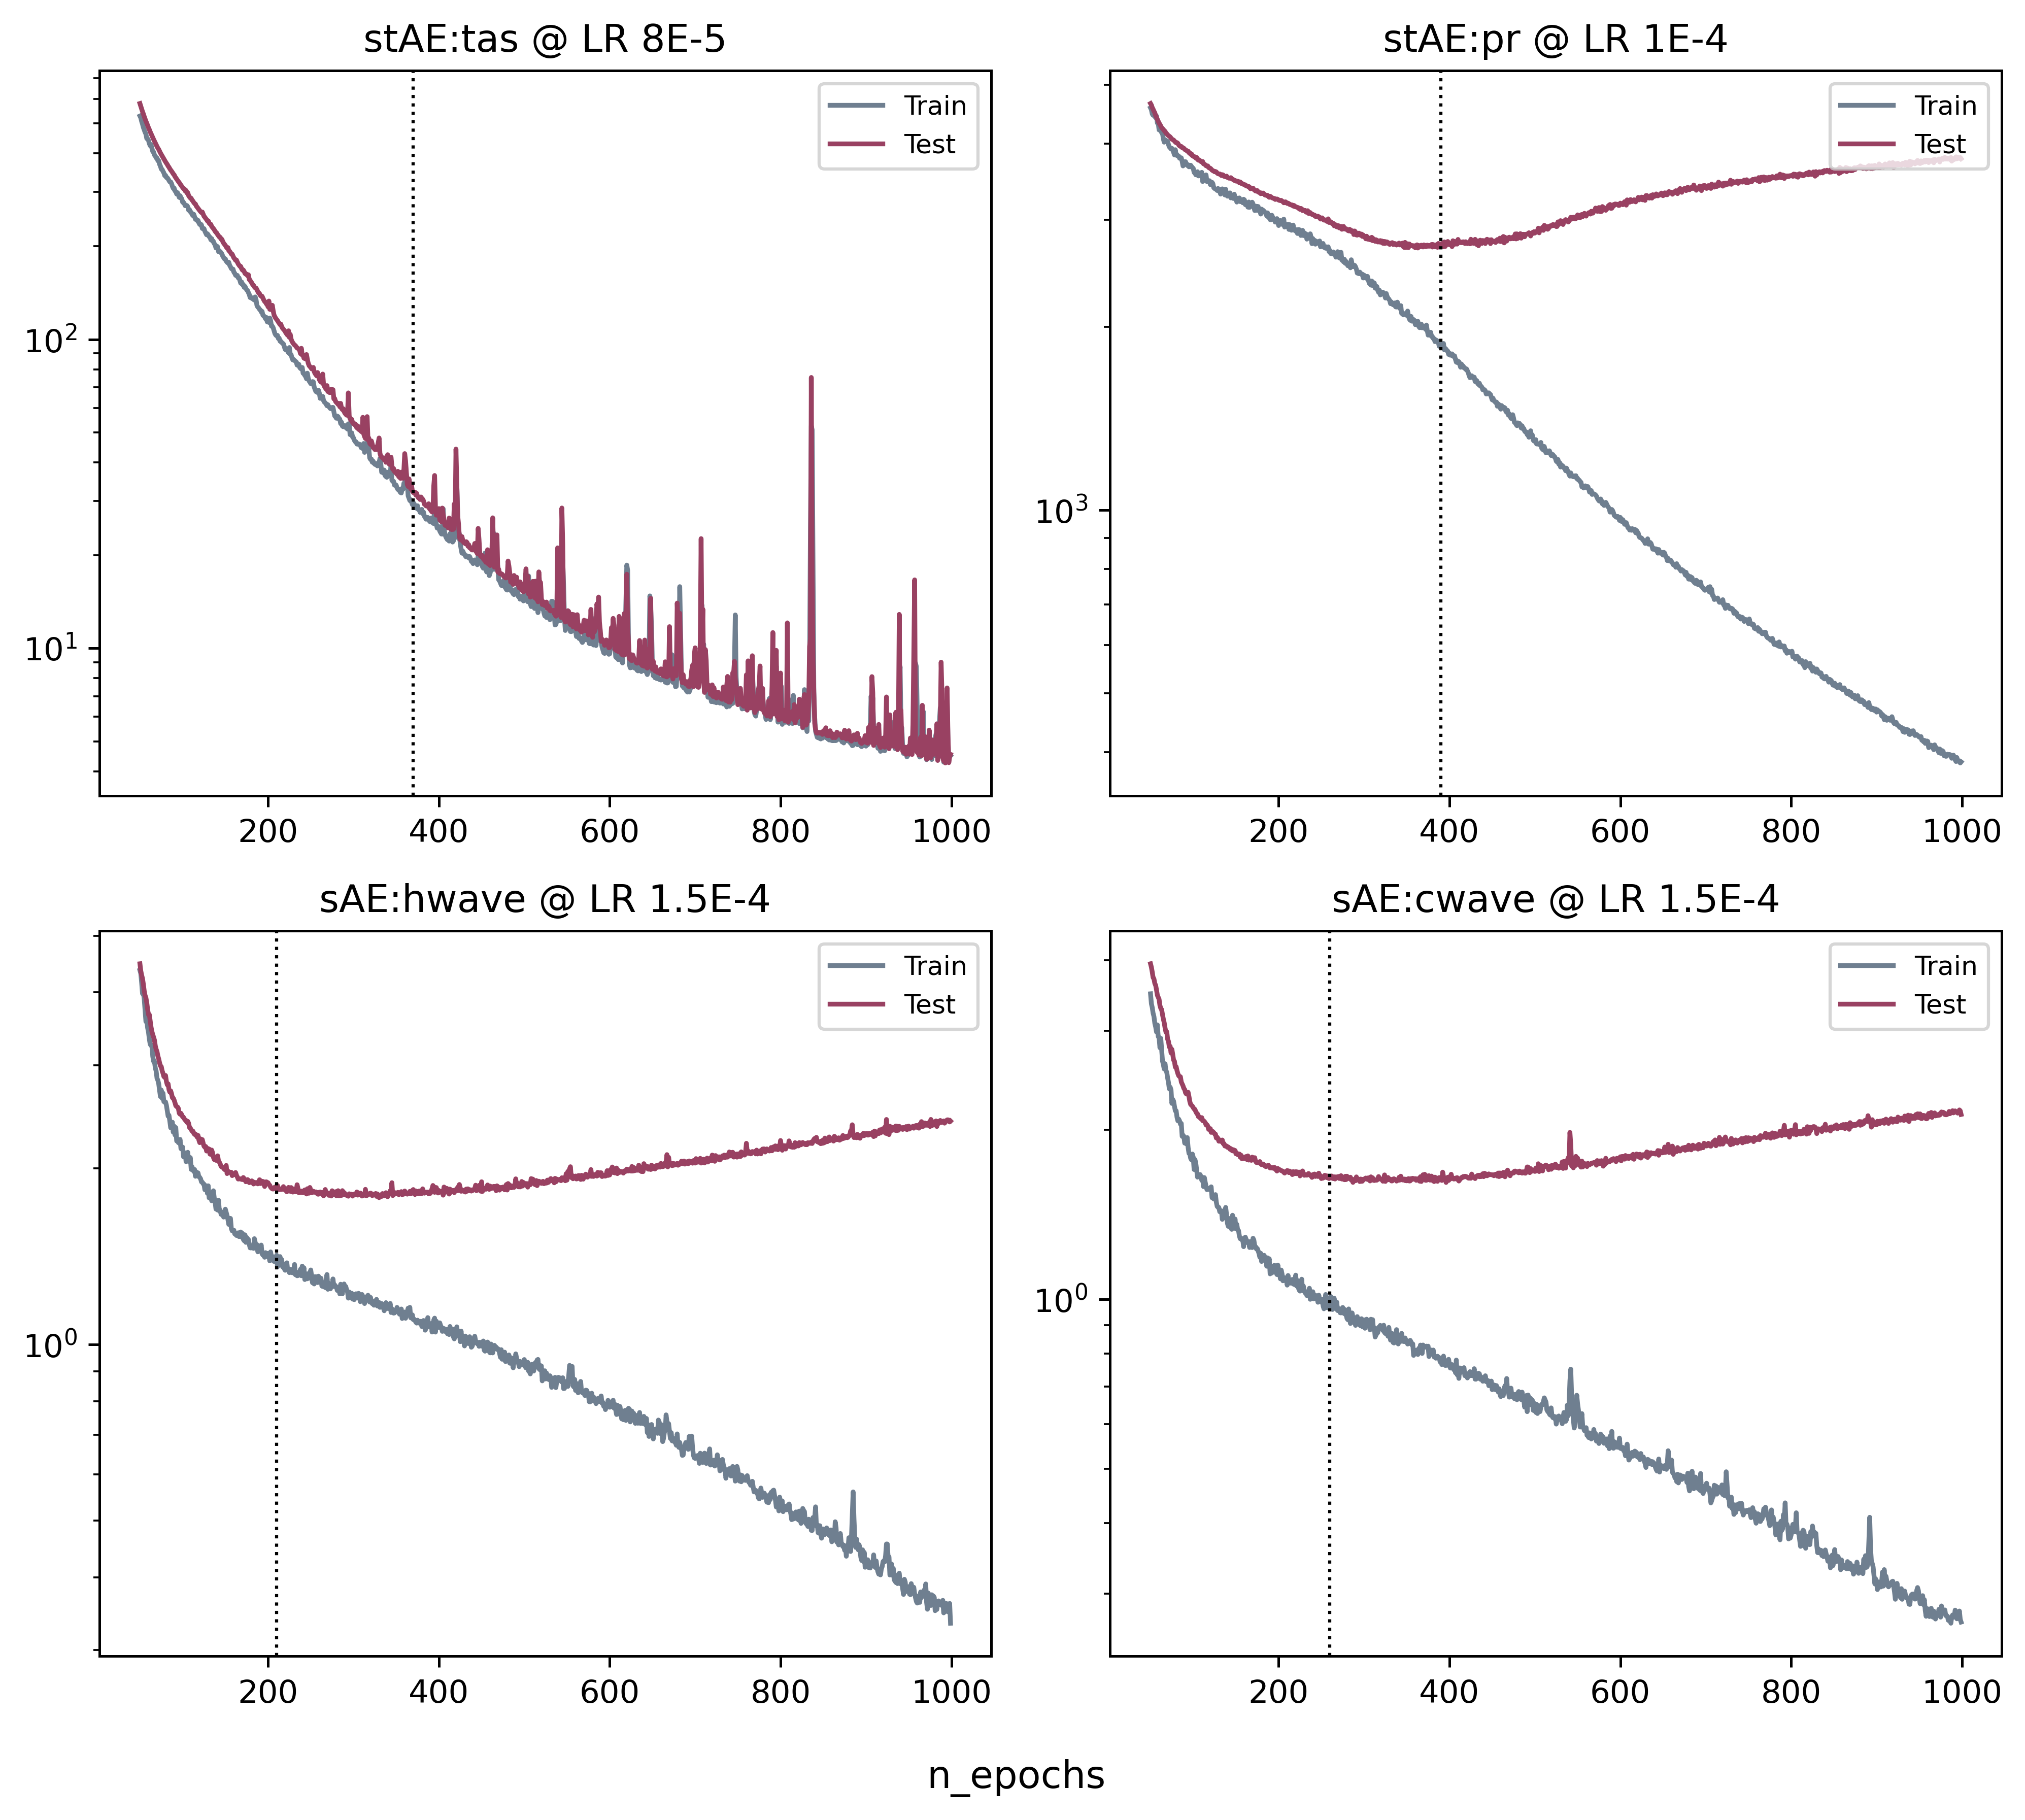

In [28]:
c1='#6f7f90'
c2='#994162'

fig, ax= plt.subplots(2,2,figsize=(9, 8), dpi=450)

plotax(datas, ax[0][0], title='stAE:tas @ LR 8E-5')
plotax(dapr, ax[0][1], title='stAE:pr @ LR 1E-4')
plotax(dahw, ax[1][0], title='sAE:hwave @ LR 1.5E-4')
plotax(dacw, ax[1][1], title='sAE:cwave @ LR 1.5E-4')

ax[0][0].axvline(370, ls=':', lw=1, c='black')
ax[0][1].axvline(390, ls=':', lw=1, c='black')
ax[1][0].axvline(210, ls=':', lw=1, c='black')
ax[1][1].axvline(260, ls=':', lw=1, c='black')

fig.supxlabel('n_epochs')

#fig.suptitle('Autoencoder Training Losses at different epochs')
fig.tight_layout()

## Final Epochs

In [265]:
#heatwave

n = 8  # Dimensionality of the encoded representation
b_size = 32
num_epochs = 210
learning_rate = 0.00015

# Now split the data into train and test sets
num_samples = len(hw_dataset)
test_size = int(0.1 * num_samples)
train_size = num_samples - test_size
train_dataset, test_dataset = random_split(hw_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(66))

train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

heat_aencoder = Autoencoder(n)
heat_aencoder.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(heat_aencoder.parameters(), lr=learning_rate)

# Train the model
train_aencoder(heat_aencoder, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)

#coldwave

n = 8  # Dimensionality of the encoded representation
b_size = 32
num_epochs = 260
learning_rate = 0.00015

# Now split the data into train and test sets
num_samples = len(cw_dataset)
test_size = int(0.1 * num_samples)
train_size = num_samples - test_size
train_dataset, test_dataset = random_split(cw_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(66))

train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

cold_aencoder = Autoencoder(n)
cold_aencoder.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(cold_aencoder.parameters(), lr=learning_rate)

# Train the model
train_aencoder(cold_aencoder, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)

#tas

n = 8  # Dimensionality of the encoded representation
b_size = 32
num_epochs = 370
learning_rate = 0.00008

# Now split the data into train and test sets
num_samples = len(tas_dataset)
test_size = int(0.1 * num_samples)
train_size = num_samples - test_size
train_dataset, test_dataset = random_split(tas_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(594687))

train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

tas_stae = MonthlyAutoencoder(n)
tas_stae.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(tas_stae.parameters(), lr=learning_rate)

# Train the model
train_aencoder(tas_stae, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)

#pr

n = 8  # Dimensionality of the encoded representation
b_size = 32
num_epochs = 390
learning_rate = 0.0001

# Now split the data into train and test sets
num_samples = len(pr_dataset)
test_size = int(0.1 * num_samples)
train_size = num_samples - test_size
train_dataset, test_dataset = random_split(pr_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(2345))

train_loader = DataLoader(train_dataset, batch_size=b_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=b_size, shuffle=False)

pr_stae = MonthlyAutoencoder(n)
pr_stae.train()

criterion = nn.MSELoss()
optimizer = optim.Adam(pr_stae.parameters(), lr=learning_rate)

# Train the model
_ = train_aencoder(pr_stae, train_loader, test_loader, criterion, optimizer, num_epochs=num_epochs)

Using device: cuda
Using device: cuda
Using device: cuda
Using device: cuda


([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

In [268]:
heat_aencoder.eval()
cold_aencoder.eval()
tas_stae.eval()
pr_stae.eval()

MonthlyAutoencoder(
  (encoder): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (3): ReLU()
    (4): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6272, out_features=128, bias=True)
    (8): Softplus(beta=1, threshold=20)
    (9): Linear(in_features=128, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=128, out_features=6272, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(64, 2, 7, 7))
    (5): ConvTranspose3d(64, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), output_padding=(1, 1, 1))
    (6): ReLU()
    (7): ConvTranspose3d(32, 16, kernel_size=(3, 3

In [22]:
class ActivationHook:
    def __init__(self):
        self.activations = []

    def hook(self, module, input, output):
        print("Hook triggered")
        self.activations.append(output.detach())

# Create a list to store the hooks
activation_hooks = []

# Register hooks to convolutional layers in the encoder
for layer in heat_aencoder.encoder.modules():
    if isinstance(layer, nn.Conv2d):
        print('yes')
        hook = ActivationHook()
        layer.register_forward_hook(hook.hook)
        activation_hooks.append(hook)

yes
yes


In [ ]:
heat_aencoder(torch.from_numpy(hw_arr).float().unsqueeze(1).to('cuda'))

# Select a single example from the batch for visualization
# Change the index 0 to any other index to visualize activations of another example
example_index = 60

for hook in activation_hooks:
    # Get activations for the chosen example
    activations = hook.activations[0][example_index]

    num_filters = activations.size(0)

    # Create a grid of subplots
    fig, axes = plt.subplots(1, num_filters, figsize=(num_filters * 2, 2))

    for i in range(num_filters):
        # Get the activation of the ith filter
        activation = activations[i].cpu().numpy()

        # Plot the activation
        axes[i].imshow(activation, cmap='gray')
        axes[i].axis('off')

    plt.show()

In [269]:
torch.save(heat_aencoder, 'model/heat.pth')
torch.save(cold_aencoder, 'model/cold.pth')
torch.save(tas_stae, 'model/tas.pth')
torch.save(pr_stae, 'model/pr.pth')

# Plotting

In [14]:
# Loadback

heat_aencoder=torch.load('model/heat.pth')
cold_aencoder=torch.load('model/cold.pth')
tas_mencoder=torch.load('model/tas.pth')
pr_mencoder=torch.load('model/pr.pth')

In [15]:
from torchviz import make_dot, make_dot_from_trace

In [16]:
batch_size=2

c_batch = torch.empty(batch_size, 1, 50, 50)
for i in range(batch_size):
    c_batch[i] = torch.randn(1, 50, 50)
dd=torch.randn(1, 12, 52, 52)


output = heat_aencoder(c_batch)

# Visualize the model
vis_graph = make_dot(output, params=dict(heat_aencoder.named_parameters()))
vis_graph.view() 

'Digraph.gv.pdf'